# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. 
В нём можно быстро узнать рыночную стоимость своего автомобиля. 
В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 
Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**
* DateCrawled — дата скачивания анкеты из базы;
* VehicleType — тип автомобильного кузова;
* RegistrationYear — год регистрации автомобиля;
* Gearbox — тип коробки передач;
* Power — мощность (л. с.);
* Model — модель автомобиля;
* Kilometer — пробег (км);
* RegistrationMonth — месяц регистрации автомобиля;
* FuelType — тип топлива;
* Brand — марка автомобиля;
* NotRepaired — была машина в ремонте или нет;
* DateCreated — дата создания анкеты;
* NumberOfPictures — количество фотографий автомобиля;
* PostalCode — почтовый индекс владельца анкеты (пользователя);
* LastSeen — дата последней активности пользователя;
* Price — цена (евро).

## Data pre-processing

In [1]:
!pip install category_encoders
!pip install catboost
!pip install lightgbm

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 82 kB 338 kB/s eta 0:00:011
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [1]:
import pandas as pd
import numpy as np

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
#Q-Q-plot
import statsmodels.api as sm

# numerical and categorical features preprosessing
from sklearn.preprocessing import StandardScaler
from category_encoders.hashing import HashingEncoder
from sklearn.model_selection import train_test_split

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.dummy import DummyRegressor

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import time
from timeit import default_timer as timer

import warnings
warnings.filterwarnings("ignore")

In [2]:
STATE = 30
CURRENT_YEAR = 2021

Загрузим данные и проверим основную информацию.

In [3]:
def first_glance(directory, title, **kwargs):
    '''
    Загружает данные; 
    Печатает: 
            Общая информация, 
            5 случайных строк, 
            Количество дубликатов, 
            Количество и процентное соотношение пропусков.
    
    Параметры
    ----------
    directory: str
        Расположение csv файла
    title: str
        Название файла
        
    Возвращает 
    ----------
    DataFrame
    
    '''
    data = pd.read_csv(directory, **kwargs)
    display(title)
    print('-------------Общая информация---------------')
    display(data.info())

    print('------------5 случайных строк---------------') 
    display(data.sample(5, random_state=STATE))
    print()
    
    if data.duplicated().sum().sum() != 0:
        display('-------Количество дубликатов---------', 
        data.duplicated().sum())
    else:
        print('Полные дубликаты отсутствуют')

    if data.isna().sum().sum() != 0:
        # создает датафрейм с количеством пропусков в каждой колонке
        na_values = data.isna().sum().to_frame().rename(columns = {0: 'пропуски'})
        # добавляет новую колонку с процентом пропусков
        na_values['% от общего количества'] = (na_values['пропуски'] / data.shape[0]).round(2)
        # сортирует таблицу по убыванию количества пропусков
        display('--Количество и процентное соотношение пропусков--',
                na_values.sort_values(by = 'пропуски', ascending = False))
    else:
        print('Пропуски отсутствуют')

    print()
    
    print('----------Описательная статистика----------')
    display(data.describe().T)
    
    return data

In [4]:
data = first_glance('autos.csv', 'Autos')
display()

'Autos'

-------------Общая информация---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           3543

None

------------5 случайных строк---------------


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
136238,2016-04-02 18:38:55,5300,sedan,2005,manual,102,golf,80000,10,petrol,volkswagen,no,2016-04-02 00:00:00,0,87437,2016-04-02 18:38:55
8121,2016-03-08 00:38:17,6499,small,2012,manual,75,polo,150000,4,gasoline,volkswagen,no,2016-03-07 00:00:00,0,4860,2016-04-07 11:44:34
203231,2016-03-22 14:56:56,4900,small,2009,manual,75,colt,80000,11,petrol,mitsubishi,no,2016-03-22 00:00:00,0,44651,2016-04-06 04:17:02
327426,2016-03-12 17:54:22,125,small,2000,manual,50,1_reihe,125000,0,petrol,mazda,yes,2016-03-12 00:00:00,0,8209,2016-04-05 07:48:38
157429,2016-03-28 14:43:41,750,NaN,2017,manual,0,corsa,100000,9,NaN,opel,NaN,2016-03-28 00:00:00,0,50226,2016-04-06 18:44:31


'-------Количество дубликатов---------'

4

'--Количество и процентное соотношение пропусков--'

,пропуски,% от общего количества
NotRepaired,71154,0.20
VehicleType,37490,0.11
FuelType,32895,0.09
Gearbox,19833,0.06
Model,19705,0.06
DateCrawled,0,0.00
Price,0,0.00
RegistrationYear,0,0.00
Power,0,0.00
Kilometer,0,0.00



----------Описательная статистика----------


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


In [7]:
df = data.copy()

In [8]:
df.columns = df.columns.str.lower()

In [9]:
df.columns = ['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type', 'brand',
       'not_repaired', 'date_created', 'number_of_pictures', 'postal_code',
       'last_seen']

In [10]:
def group_columns(df):
    numeric_columns = []
    categorical_columns = []

    for column in df.columns:
        if df[column].dtype.name in ['int64', 'float64', 'bool']:
            numeric_columns.append(column)
        if df[column].dtype.name in ['object', 'category']:
            categorical_columns.append(column)  
            
    return categorical_columns, numeric_columns

In [11]:
categorical_columns, numeric_columns = group_columns(df)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
date_crawled          354369 non-null object
price                 354369 non-null int64
vehicle_type          316879 non-null object
registration_year     354369 non-null int64
gearbox               334536 non-null object
power                 354369 non-null int64
model                 334664 non-null object
kilometer             354369 non-null int64
registration_month    354369 non-null int64
fuel_type             321474 non-null object
brand                 354369 non-null object
not_repaired          283215 non-null object
date_created          354369 non-null object
number_of_pictures    354369 non-null int64
postal_code           354369 non-null int64
last_seen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


Построим графики для каждой числовой колонки.

In [13]:
def visualize_info(df, columns):
    '''
    В виде подграфиков:
        Выводит информацию describe;
        Строит графики:
            диаграмма размаха;
            гистограмма;
            график квантиль-квантиль.
    
     Параметры
     ----------
     df: DataFrame
         таблица для графика
     columns: str
         названия колонок с численными данными
    '''
    fig, ax = plt.subplots(len(columns), 4, gridspec_kw={'wspace': 0.5, 'hspace': 0.3})
    fig.set_figheight(5 * len(columns))
    fig.set_figwidth(17)
    
    for i, column in enumerate(columns):
        ax_plot = [ax[i,0], ax[i,1], ax[i,2], ax[i,3]]

        # describe info
        describe_series = round(df[column].describe())
        # creating a table with reshaped series.describe() 
        describe_table = ax_plot[0].table(
            cellText=describe_series.values.reshape(describe_series.shape[0],1),
            rowLabels=list(describe_series.index),
            colLabels=[column],
            colWidths = [0.9],
            loc = 'center'
                                         )
        ax_plot[0].grid(False)
        ax_plot[0].axis('off')
        describe_table.scale(1, 2)
        describe_table.auto_set_font_size(False)
        describe_table.set_fontsize(15)
        
        # violin plot
        sns.violinplot(data=df[column], ax=ax_plot[1], color='salmon')
        ax_plot[1].set_xlabel(column, fontsize = 15)
        
        # density plot
        sns.distplot(a=df[column], kde=True, ax=ax_plot[2], color='olive')
        ax_plot[2].set_xlabel(column, fontsize = 15)
        ax_plot[2].set_ylabel('Density', fontsize = 14)
        
        # qq-plot
        sm.qqplot(df[column].astype(np.float64), ax=ax_plot[3], fit=True, line='45')
        ax_plot[3].set_xlabel('Theoretical Quantiles', fontsize = 15)
        ax_plot[3].set_ylabel('Sample Quantiles', fontsize = 15)

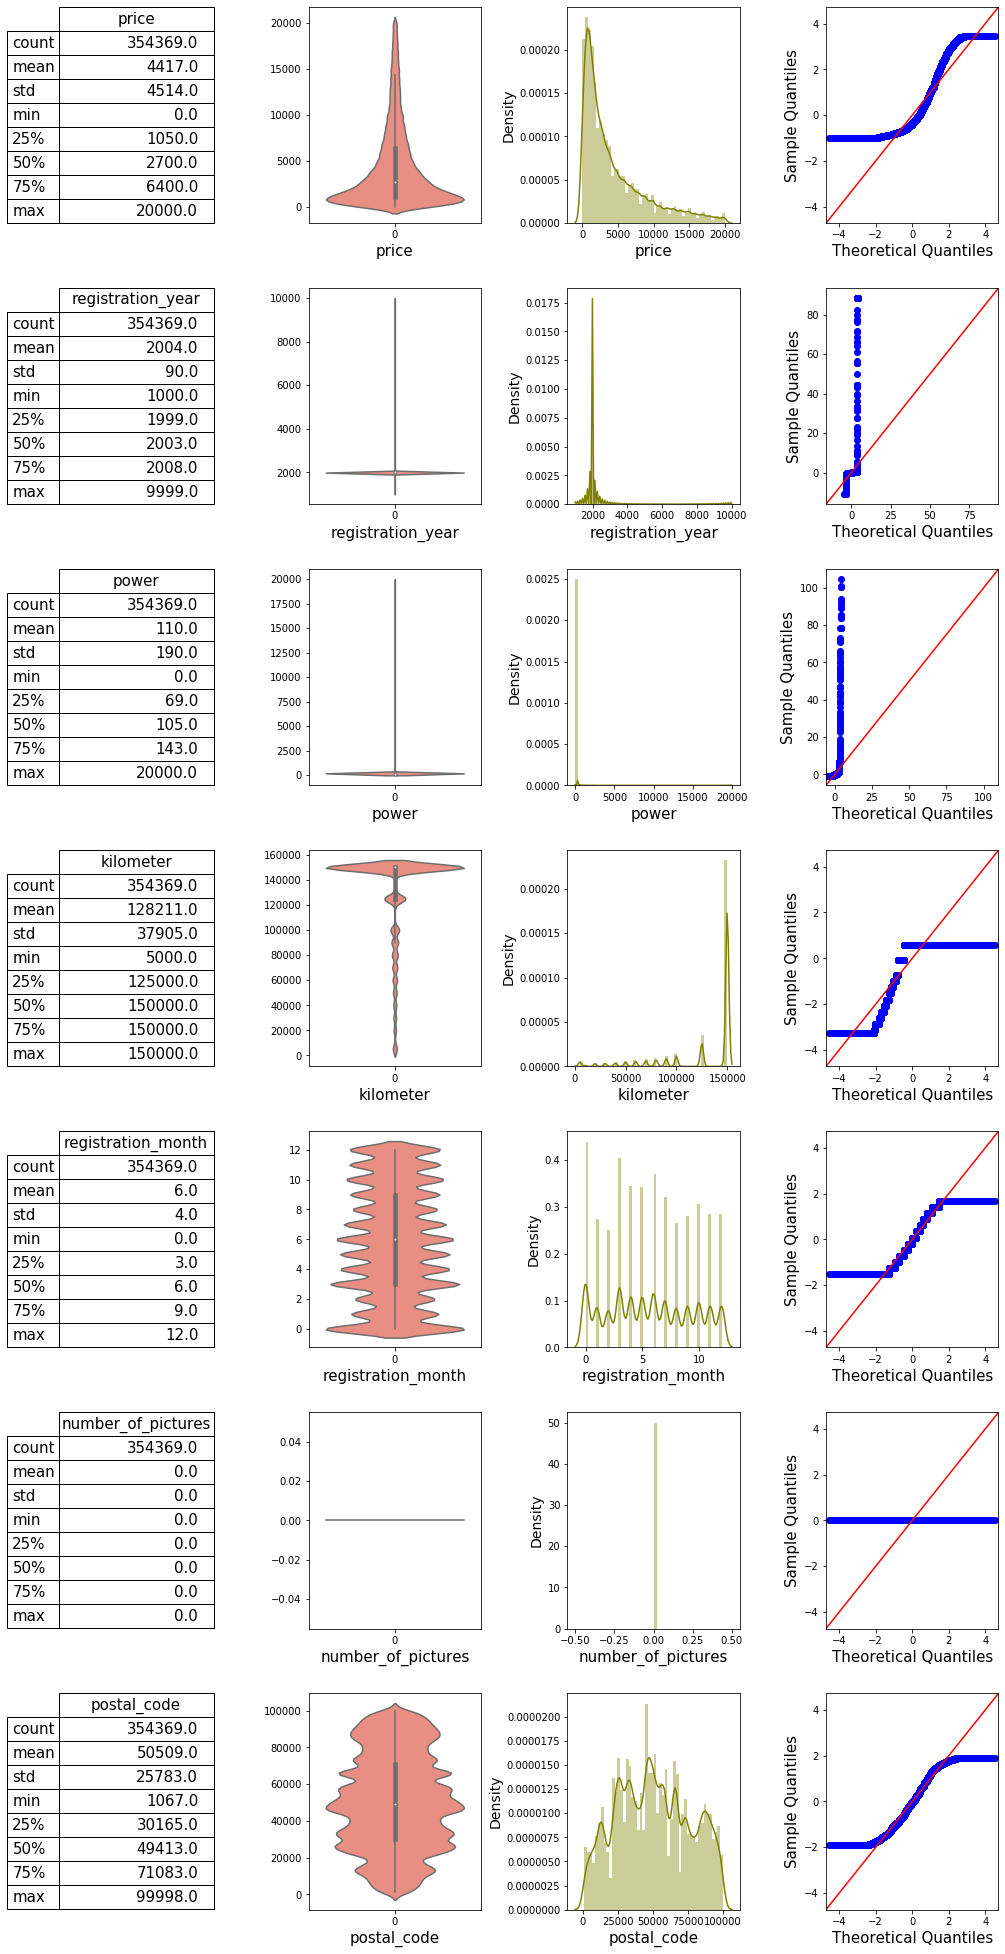

In [14]:
visualize_info(df, numeric_columns)

In [15]:
categorical_columns

['date_crawled',
 'vehicle_type',
 'gearbox',
 'model',
 'fuel_type',
 'brand',
 'not_repaired',
 'date_created',
 'last_seen']

Проверим зависимость признаков в данных и нормальность распределений признаков.

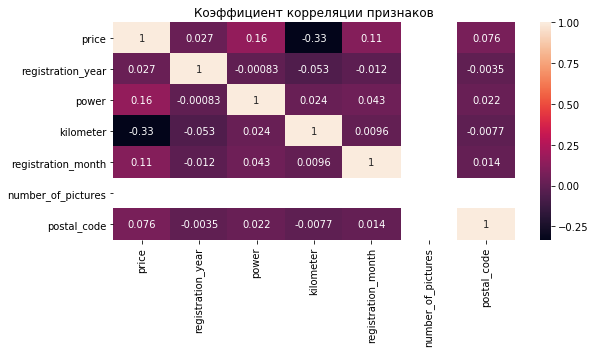

In [16]:
plt.figure(figsize=(9, 4))
ax = plt.axes()
sns.heatmap(df.corr(), annot=True, ax = ax)
ax.set_title("Коэффициент корреляции признаков")
plt.show()

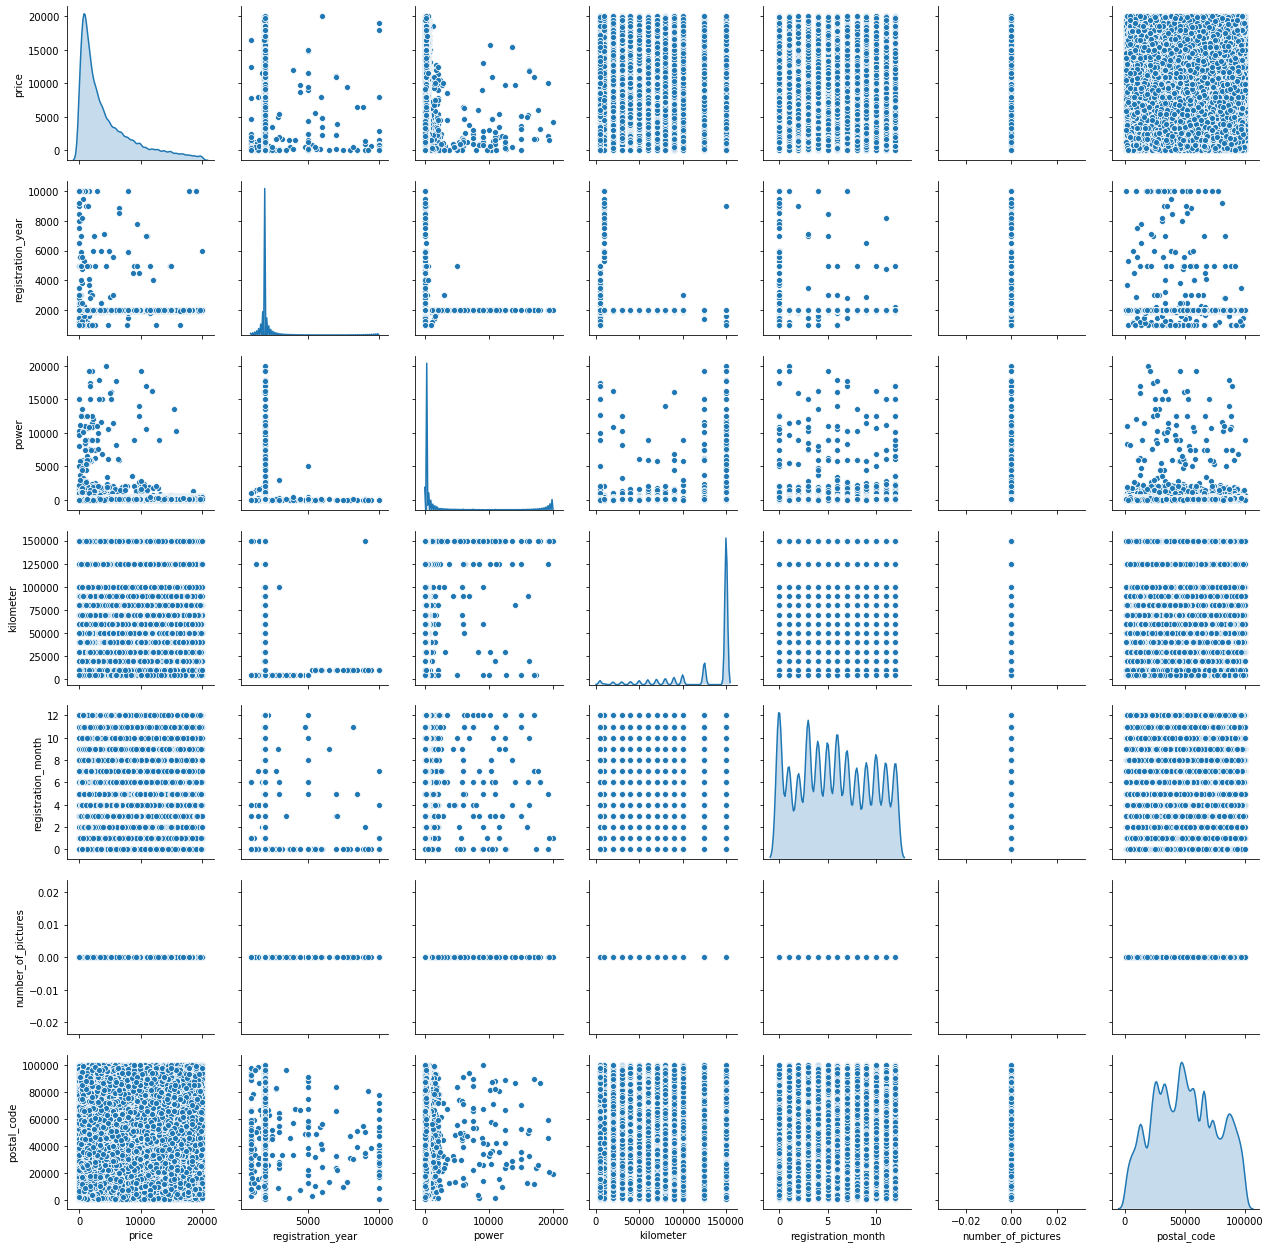

In [17]:
sns.pairplot(df, diag_kind="kde", dropna=True)
plt.title = "Зависимость признаков"

Явная линейная зависимоть между парами признаков отсутствует.

### Data cleaning

In [18]:
def cast_type(df, int_columns=None, category_columns=None, 
           date_columns=None, date_format="Y%m%d"):
    
    if date_columns != None:
        for column in date_columns:
            df[column] = pd.to_datetime(df[column], format=date_format)

    if int_columns  != None:
        df[int_columns] = round(df[int_columns]).astype('Int64')
        
    if category_columns != None:
        df[category_columns] = df[category_columns].astype('category')
        
    return df   

In [19]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [20]:
df = cast_type(df,
          category_columns=['vehicle_type', 'fuel_type', 'gearbox', 
                            'registration_month', 'brand', 'model'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
date_crawled          354369 non-null object
price                 354369 non-null int64
vehicle_type          316879 non-null category
registration_year     354369 non-null int64
gearbox               334536 non-null category
power                 354369 non-null int64
model                 334664 non-null category
kilometer             354369 non-null int64
registration_month    354369 non-null category
fuel_type             321474 non-null category
brand                 354369 non-null category
not_repaired          283215 non-null object
date_created          354369 non-null object
number_of_pictures    354369 non-null int64
postal_code           354369 non-null int64
last_seen             354369 non-null object
dtypes: category(6), int64(6), object(4)
memory usage: 29.4+ MB


#### Removing and filling NA

Удалим полные дубликаты из данных.

In [21]:
print('before',  df.shape[0])
df = df.drop_duplicates()
print('after', df.shape[0])

before 354369
after 354365


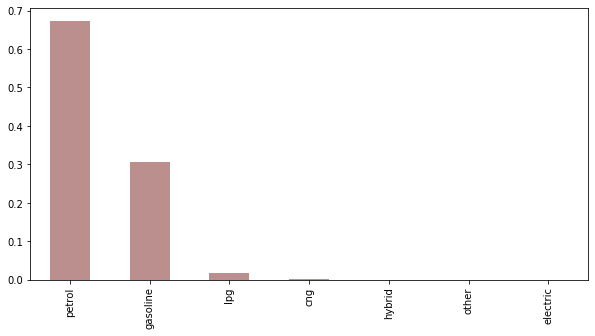

In [22]:
plt.figure(figsize=(10,5))
df['fuel_type'].value_counts(normalize=True).plot(kind='bar', color='rosybrown')
plt.show()

In [23]:
df['fuel_type'] = df['fuel_type'].fillna('other')
df['vehicle_type'] = df['vehicle_type'].fillna('other')
df['vehicle_type'].isna().sum()

0

Заменим пропущенные значения в столбце об отсутствии ремонта на 'yes', предположив, что ремонт в этих случаях не производился.

In [24]:
print('Уникальные значения в колонке', df['not_repaired'].unique())
df['not_repaired'] = df['not_repaired'].fillna('yes')
print('Количество пропусков после замены', df['not_repaired'].isna().sum())

Уникальные значения в колонке [nan 'yes' 'no']
Количество пропусков после замены 0


Переведем значения "да" и "нет" в 1 и 0, далее присвоим данному столбцу булев тип. 

In [25]:
df['not_repaired'] = df['not_repaired'].map({'yes':1, 'no':0}).astype('bool')

Обработаем пропуски в тех столбцах, где они не превышают 7%.

In [26]:
def drop_na(df):
    '''
    Deletes rows with NA values in any column, 
    in which the percentage of NA values no greater than 7% after deleting in other columns. 
    
    Parameters
    ----------
    df: Dataframe
        a dataframe to remove NA by columns
    
    Returns
    ----------
    Dataframe
    ''' 
  
    for column in df.columns:
        na_count = df[column].isna().sum()
        na_percent = na_count / df.shape[0] * 100
        
        if na_count > 1 and na_percent < 7:
            print(f"will drop NA in the column '{column}': NA_count: {na_count}")
            df = df.dropna(subset=[column])    
    return df

In [27]:
df = drop_na(df)

will drop NA in the column 'gearbox': NA_count: 19833
will drop NA in the column 'model': NA_count: 15574


In [28]:
df.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
not_repaired          0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

#### Removing anomaly values

Удалим те объекты, год регистрации которых указан в будущем.

In [29]:
print('Количество объектов с будущим годом регистрации', 
      df.loc[df['registration_year'] > CURRENT_YEAR]['registration_year'].count())
future_year = df.loc[df['registration_year'] > CURRENT_YEAR].index

df = df.drop(index=future_year, axis=0)
print('Количество после удаления', 
      df.loc[df['registration_year'] > CURRENT_YEAR]['registration_year'].count())

Количество объектов с будущим годом регистрации 19
Количество после удаления 0


Удалим значения с годом регистрации ранее 1885 года (приблизительный год начала массового выпуска автомобилей в мире).

In [30]:
early_year = df.loc[df['registration_year'] < 1885].index
df = df.drop(index=early_year, axis=0)
df.loc[df['registration_year'] < 1885]['registration_year'].count()

0

Проверим диаграммы размаха мощности по типу транспортного средства.

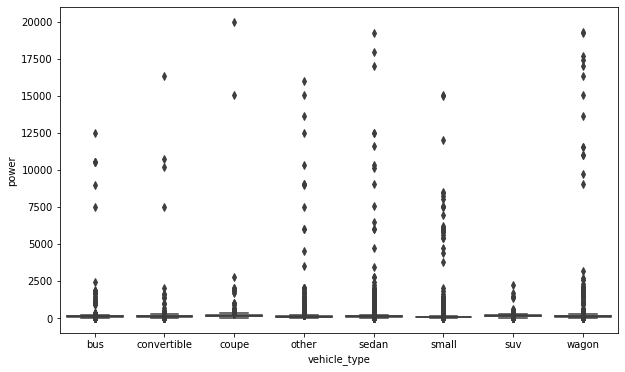

In [31]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='vehicle_type', y='power')
plt.show()

Оставим транспортные средства, мощность которых не превышает 600 л.с., т.к. в эти данные войдут владельцы внедорожников, а владельцы более мощных спортивных автомобилей не являются основой целевой аудиторией данного сервиса.

In [32]:
print(df.loc[df['power'] > 600]['power'].count())
over_power = df.loc[df['power'] > 600].index
df = df.drop(index=over_power, axis=0)
df.loc[df['power'] > 600]['power'].count()

312


0

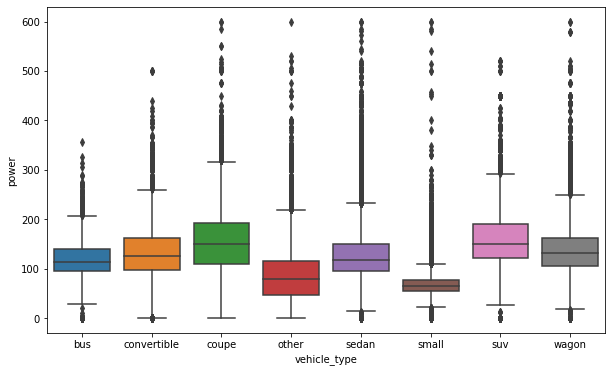

In [33]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='vehicle_type', y='power')
plt.show()

Заметны выбросы данных около нуля, можно предположить, что такая ситуация возможна если владелец не указал мощность или не знает ее.

Еще раз проверим целевой признак.

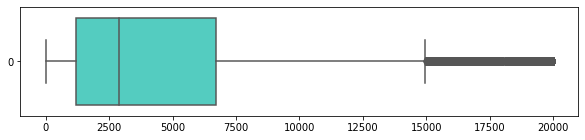

In [34]:
plt.figure(figsize=(10, 2))
sns.boxplot(data=df['price'], orient='h', color='turquoise')
plt.show()

Удалим признаки с датами создания анкеты, скачивания анктеты и последнего посещения.
Также удалим признак с почтовым индексом и количеством фото (константный признак). Данные признаки не являются значимыми для прогнозирования цены транспортного средства.

In [35]:
df = df.drop(['date_crawled', 'date_created', 'last_seen', 'number_of_pictures', 'postal_code'], 
             axis=1)

In [37]:
len(df['model'].unique())

250

### Samples preparation

Создадим родительский класс, который будет включать в себя подготовку данных для обучения моделей:
* выделение целевого признака;
* разбиение на выборки;
* кодирование данных;
* масштабирование данных.

In [38]:
class Samples_Preparation:
    state = 30
    
    def __init__(self, df, target_col):
        self.df = df    
        self.features = self.df.drop(target_col, axis=1)
        self.target = self.df[target_col]
    
    def train_test_split(self):
        features_train, features_test, target_train, target_test = train_test_split(
                self.features, self.target, 
                test_size=0.2, random_state=self.state)
        
        self.features_train = features_train
        self.target_train = target_train
        self.features_test = features_test
        self.target_test = target_test
        
        return features_train, features_test, target_train, target_test   
   
    def encoder_hash(self):
        
        encoder_hash = HashingEncoder()
        encoder_hash.fit(self.features_train)
        transform_res = encoder_hash.transform(
                                        self.features_train)
        
        self.features_train = transform_res
        self.features_test = encoder_hash.transform(self.features_test)
    
    def group_columns(self):
        numeric_columns = []
        categorical_columns = []

        for column in self.features_train.columns:
            if self.features_train[column].dtype.name in ['int64', 'float64', 'bool']:
                numeric_columns.append(column)
            if self.features_train[column].dtype.name in ['object', 'category']:
                categorical_columns.append(column)  
            
        return categorical_columns, numeric_columns

    def scale(self):
        scaler = StandardScaler()
        pd.options.mode.chained_assignment = None
        
        self.categorical_columns, self.numeric_columns = self.group_columns()
                            
        
        scaler.fit(self.features_train[self.numeric_columns])
        self.features_train[self.numeric_columns] = scaler.transform(
                                 self.features_train[self.numeric_columns])
        self.features_test[self.numeric_columns] = scaler.transform(
                                 self.features_test[self.numeric_columns])
        
    def info(self):
        print(self.features_train.info())
        print(self.features_test.info())

### Summary


Имеется файл с данными, которых содержит 354369 объектов.
Имеются дубликаты.
Имеются пропуски в признаках NotRepaired, VehicleType, FuelType, Gearbox, Model.

Явная линейная зависимоть между парами признаков отсутствует, но есть небольшая обратная зависимость между пробегом автомобиля и ценой. 

Часть признаков распределены нормально, 
в других имеются заметные выбросы.

Проведена предобработка данных:
* изменены типы данных на булев тип и категориальные (которые подходят для работы некоторых моделей);

* удалены признаки с датами создания анкеты, скачивания анктеты и последнего посещения. Данные признаки не являются значимыми для прогнозирования цены транспортного средства;

* удалены полные дубликаты;

* обработаны пропуски - удалены или заменены на новую категорию;

* обработаны аномальные значения;

* оставлены те транспортные средства, мощность которых не превышает 600 л.с., т.к. в эти данные войдут владельцы внедорожников, а владельцы более мощных спортивных автомобилей не являются основой целевой аудиторией данного сервиса;

* удалены незначимые признаки - дата создания анкеты, дата скачивания анкеты, дата последнего посещения;



* создан класс для подготовки выборок для дальнейшего обучения моделей, включающий:

    * выделение целевого признака;
    * разбиение на выборки;
    * кодирование данных;
    * масштабирование данных.

## Training models

### Hyperparameter optimization

Создадим подкласс, который включает в себя алгоритм поиска по сетке 
гиперпараметров с обучением модели и тестирование модели.

В качестве метрики оценки качества модели будем использовать RMSE.

In [39]:
class Models(Samples_Preparation):
    
    def grid_search(self, grid_params, **kwargs):
        model = self.model_algorithm(**kwargs)
        
        grid = GridSearchCV(model, grid_params, n_jobs= -1, cv=5, scoring='neg_root_mean_squared_error')
        self.model_grid = grid.fit(self.features_train, self.target_train)
        
        return self.model_grid
    
    def fit_predict(self):
        self.predicted_test = self.model_grid.predict(self.features_test)
        
        return self.predicted_test
    
    def rmse(self):
        rmse = round(mean_squared_error(
                                self.target_test, self.predicted_test) ** 0.5)
    
        return rmse


### Linear Regression

Подкласс для обучения и тестирования линейной регрессии.

In [40]:
class Linear_Reg(Models):
    def __init__(self, df, target_col):
        super().__init__(df, target_col)
        self.model_algorithm = LinearRegression
        self.name = 'Linear_Regression'
    
    def grid_search(self):
        print('This model does not use GridSearch')
        
    def fit_predict(self):
        model = LinearRegression(fit_intercept=True)
        model.fit(self.features_train, self.target_train)
        self.predicted_test = model.predict(self.features_test)
    
        return model, self.predicted_test 

### CatBoost Regressor

Подкласс для использования модели CatBoost.

In [41]:
class Catboost_Reg(Models):
    
    def __init__(self, df, target_col):
        super().__init__(df, target_col)
        self.model_algorithm = CatBoostRegressor
        self.name = 'CatBoost_Regressor'
        
    def encoder_hash(self):
        print('This model does not require encoding of string types')
    
    def grid_search(self):
        
        grid_params = {'learning_rate': [0.1, 0.2, 0.3, 0.5],
              'depth': [2, 4, 6, 8]}
             
        super().grid_search(grid_params, 
                            iterations=1000, 
                            cat_features=self.categorical_columns) 

### Light GBM Regressor

Подкласс для использования модели LightGBM.

In [42]:
class LightGBM(Models):
    
    def __init__(self, df, target_col):
        super().__init__(df, target_col)
        self.model_algorithm = LGBMRegressor
        self.name  = 'LGBM_Regressor'
        
    def encoder_hash(self):
        print('This model does not require encoding of category types')
        
    def grid_search(self):
        
        grid_params = {'learning_rate': [0.1, 0.2, 0.3, 0.5],
              'max_depth': [2, 4, 6, 8]}
             
        super().grid_search(grid_params, 
                            num_iterations=1000, 
                            
                            verbose=4,
                            random_state=self.state)

### Random Forest Regressor

Подкласс для использования модели случайного леса.

In [43]:
class Forest_Reg(Models):

    def __init__(self, df, target_col):
        super().__init__(df, target_col)
        self.model_algorithm = RandomForestRegressor
        self.name = 'Random_Forest_Regressor'
        
    def grid_search(self):
        
        grid_params = {'n_estimators': range (10, 51, 10),
              'max_depth': range (1, 13, 2)}
             
        super().grid_search(grid_params, random_state=self.state)

### Constant Model

Подкласс для обучения и тестирования константной модели.

In [56]:
class Constant_Model(Models):
    
    def __init__(self, df, target_col):
        super().__init__(df, target_col)
        self.model_algorithm = DummyRegressor
        self.name = 'Constant_Model'
            
    def grid_search(self):
        print('This model does not use GridSearch')
        
    def fit_predict(self):
        model = DummyRegressor(strategy='median')
        model.fit(self.features_train, self.target_train)
        self.predicted_test = model.predict(self.features_test)
    
        return model, self.predicted_test 

### Running Models

Запустим процесс подготовки, обучения и тестирования моделей.

In [45]:
test_df = df.loc[:100, :]
test_df.shape

(90, 13)

In [46]:
model_list = [Constant_Model, LightGBM, Catboost_Reg, Forest_Reg, Linear_Reg]
time_list = []
rmse_list = []
model_fitted = []

for model_element in model_list:
    print('--------------------------------------')
    print('Model', model_element)
    
    model = model_element(df, 'price')
    model.train_test_split()
    model.encoder_hash()
    model.scale()

    learn_start = timer()
    model.grid_search()
    learn_end = timer()
    
    predict_start = timer()
    model.fit_predict()
    predict_end = timer()

    time_list.append([model.name, learn_end - learn_start,  
                      predict_end -  predict_start])
    
    rmse_list.append(model.rmse())
    
    model_fitted.append(model)

--------------------------------------
Model <class '__main__.Constant_Model'>
This model does not use GridSearch
--------------------------------------
Model <class '__main__.LightGBM'>
This model does not require encoding of category types
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Debug] Dataset::GetMultiBinFromSparseFeatures: sparse rate 0.768112
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.155072
[LightGBM] [Debug] init for col-wise cost 0.004937 seconds, init for row-wise cost 0.016394 seconds
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 919
[LightGBM] [Info] Number of data points in 

### Summary

Выстроена структура классов для следующих моделей: 
* LightGBM Regressor;
* CatBoost Regressor;
* Random Forest Regressor;
* Linear Regression;
* Константная модель (DummyRegressor).

Найдены оптимальные гиперпараметры моделей, проведено обучение и тестирование моделей, измерена скорость работы каждой модели.

## Models Evaluation

In [66]:
time_results = pd.DataFrame(data=time_list, 
        columns=['Models', 'Learning time with GridSearch', 'Predictions time'])
time_results['Models'][0] = 'Constant_Model (no GridSearch)'
time_results['Models'][4] = 'Linear_Regression (no GridSearch)'
time_results

,Models,Learning time with GridSearch,Predictions time
0,None,NaN,NaN
1,Constant_Model (no GridSearch),0.000163,0.004077
2,LGBM_Regressor,732.769345,1.059624
3,CatBoost_Regressor,9955.819200,0.391903
4,Random_Forest_Regressor,756.671476,0.346422
5,Linear_Regression (no GridSearch),0.000165,0.179646


In [53]:
rmse_results = pd.DataFrame(data=rmse_list, columns=['RMSE'],
        index=[model_fitted[0].name, model_fitted[1].name, 
               model_fitted[2].name, model_fitted[3].name, model_fitted[4].name])
rmse_results

,RMSE
Linear_Regression,4857
LGBM_Regressor,1645
CatBoost_Regressor,1657
Random_Forest_Regressor,2042
Linear_Regression,3190


### Summary

Проанализированы скорость и качество моделей на тестовой выборке:
* самая быстрая модель - Linear_Regression с показателем RMSE 3190 (обучение и тестирование 0.000165 и 0.179646 секунд соответственно;
* самые точные модели - LGBM_Regressor и CatBoost_Regressor с показателями RMSE 1645 и 1657 соответственно.

Время, затраченное на тестирование LGBM_Regressor и CatBoost_Regressor примерно одинаковое, но время обучения и подбора параметров CatBoost_Regressor примерно в 10 раз превышает время LGBM_Regressor.


## Final Summary

По результатам проведенной работы рекомендованы следующие модели для дальнейшего внедрения:

**модель Light GBM**:
- время обучения с поиском оптимальных гиперпараметров:
  * ~ 732.77 cекунды
- время при тестировании:
  * ~ 1.06 cекунда
* показатель RMSE:
  - 1645

**модель CatBoost**:
- время обучения с поиском оптимальных гиперпараметров:
   * ~ 9955.82 cекунд
- время при тестировании:
  * ~ 0.39 cекунды
* показатель RMSE:
  - 1657